In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import scipy
import allantools

import gm2
import trfp
import plotting_functions as plt2
import analysis_helper as helper
import helper_function_candidates as helper_old


Welcome to JupyROOT 6.12/04


In [3]:
interp_df_1 = pd.read_hdf('hdf5/super-long_stationary_run.h5', 'interp_df')
moment_df_1 = helper.calc_moment_df(interp_df_1)

interp_df_2 = pd.read_hdf('hdf5/superlong_2.h5', 'tr_df')
moment_df_2 = helper.calc_moment_df(interp_df_2)

Finished calculating all moments for 252363 events.  
Finished calculating all moments for 207094 events. 


In [7]:
print np.round(np.array([np.std(np.diff(interp_df_1['tr'+str(tr)].values)) for tr in range(17)]), 3)
print np.round(np.array([np.std(np.diff(interp_df_2['tr'+str(tr)].values)) for tr in range(17)]), 2)

[0.386 0.493 0.302 0.439 0.323 0.659 0.334 0.346 0.378 0.418 1.363 0.554
 0.296 0.353 0.349 0.546 1.417]
[1.4300e+00 9.4000e-01 1.1040e+01 8.1000e-01 4.4000e-01 4.6000e-01
 7.5000e-01 2.1340e+01 5.1955e+02 3.0500e+01 1.1500e+00 4.1000e-01
 4.2000e-01 3.3000e-01 3.1000e-01 3.7000e-01 6.6000e-01]


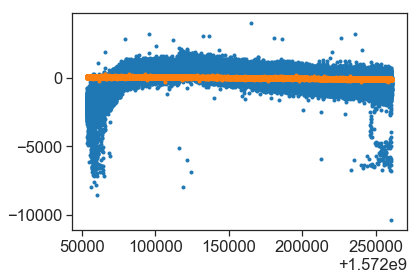

In [13]:
plt.plot(interp_df_2.index.values, interp_df_2['tr8']-np.mean(interp_df_2['tr8']), '.')
plt.plot(interp_df_2.index.values, interp_df_2['tr9']-np.mean(interp_df_2['tr9']), '.')

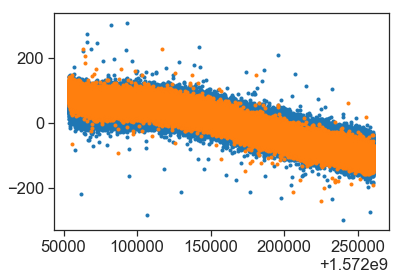

In [18]:
plt.plot(interp_df_2.index.values, interp_df_2['tr9']-np.mean(interp_df_2['tr9']), '.')
plt.plot(interp_df_2.index.values, interp_df_2['tr7']-np.mean(interp_df_2['tr7']), '.')

In [38]:
# make a new theta_tr that ignores tr8

from trfp.matrices import __multipole

TR_X_NO8 = np.array([0]
                + [1.75 * np.sin(2*np.pi/4*i)
                   for i in np.arange(4)]
                + [3.5 * np.sin(2*np.pi/12*i)
                   for i in np.arange(3)]
                + [3.5 * np.sin(2*np.pi/12*i)
                   for i in np.arange(4, 12)])
TR_Y_NO8 = np.array([0]
                + [-1.75 * np.cos(2*np.pi/4*i)
                   for i in np.arange(4)]
                + [-3.5 * np.cos(2*np.pi/12*i)
                   for i in np.arange(3)]
                + [-3.5 * np.cos(2*np.pi/12*i)
                   for i in np.arange(4,12)])

_MULTIPOLE_ORDER = [0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 7, 7]
_MULTIPOLE_SKEW = [0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1]
_MULTS = np.array([__multipole(_MULTIPOLE_ORDER[i], _MULTIPOLE_SKEW[i], 1, TR_X_NO8, TR_Y_NO8) for i in range(14)])
_MULTS[np.abs(_MULTS) < 1.0e-9] = 0 

THETA_TR_NO8 = np.linalg.pinv(np.transpose(_MULTS))
THETA_TR_NO8 = np.insert(THETA_TR_NO8, 12, np.zeros(16), 0)
THETA_TR_NO8 = np.append(THETA_TR_NO8, np.zeros([2,16]), 0)
THETA_TR_NO8[np.abs(THETA_TR_NO8) < 1.0e-9] = 0

In [47]:
THETA_TR_NO8.shape

(17, 16)

Finished calculating all moments for 252363 events.


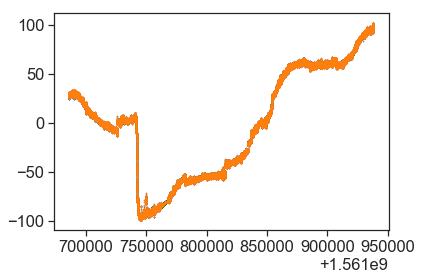

In [62]:
trs = ['tr'+str(tr) for tr in range(8)+range(9,17)]
interp_no8_df_1 = interp_df_1.copy()

moment_no8_df_1 = helper.calc_moment_df(interp_no8_df_1)
for m in range(17):
    moment_no8_df_1['tr,m'+str(m+1)] = interp_no8_df_1[trs].dot(THETA_TR_NO8[m])
    
plt.plot(moment_df_1.index.values, moment_df_1['tr,m1']-np.mean(moment_df_1['tr,m1']), '.', markersize=1)
plt.plot(moment_no8_df_1.index.values, moment_no8_df_1['tr,m1']-np.mean(moment_no8_df_1['tr,m1']), '.', markersize=1)

Finished calculating all moments for 207094 events.


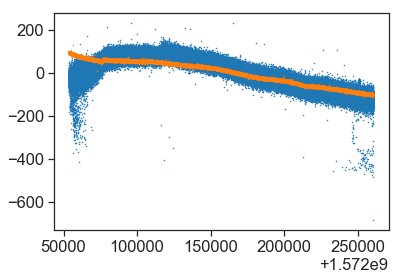

In [63]:
trs = ['tr'+str(tr) for tr in range(8)+range(9,17)]
interp_no8_df_2 = interp_df_2.copy()

moment_no8_df_2 = helper.calc_moment_df(interp_no8_df_2)
for m in range(17):
    moment_no8_df_2['tr,m'+str(m+1)] = interp_no8_df_2[trs].dot(THETA_TR_NO8[m])
    
plt.plot(moment_df_2.index.values, moment_df_2['tr,m1']-np.mean(moment_df_2['tr,m1']), '.', markersize=1)
plt.plot(moment_no8_df_2.index.values, moment_no8_df_2['tr,m1']-np.mean(moment_no8_df_2['tr,m1']), '.', markersize=1)

In [66]:
tr_baseline = np.empty((72,17))

df_mean =  np.mean(moment_no8_df_2.iloc[0:1000], axis=0).values

for i in range(72):
    tr_baseline[i, :] = df_mean[1:18]
fp_baseline = np.reshape(df_mean[18:], (72,6))

baseline_time_1 = np.empty((72,6))
baseline_time_2 = np.empty((72,6))

baseline_time_1[:,:] = moment_no8_df_2.index.values[0]
baseline_time_2[:,:] = moment_no8_df_2.index.values[-1]

fp_df = moment_no8_df_2.copy()

fp_df = fp_df.drop(columns=['tr_phi']+['tr,m'+str(m) for m in range(1,18)])

vtm_df_2 = helper.vtm_calc(fp_df, baseline_time_1, baseline_time_2, tr_baseline, tr_baseline, fp_baseline, fp_baseline)

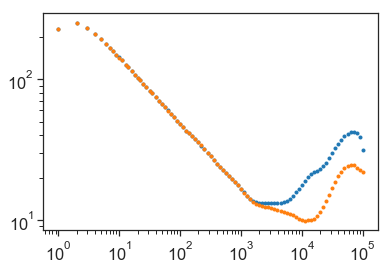

In [68]:
taus_in = np.round(np.power(10, np.arange(0,5.5,0.05)))

taus, adev, _, _ = allantools.oadev((moment_df_2['tr,m1']-vtm_df_2['st5,m1']).values, data_type='freq', rate=1, taus=taus_in)
plt.loglog(taus, adev, '.')

taus, adev, _, _ = allantools.oadev((moment_no8_df_2['tr,m1']-vtm_df_2['st5,m1']).values, data_type='freq', rate=1, taus=taus_in)
plt.loglog(taus, adev, '.')

1.8156877223090075


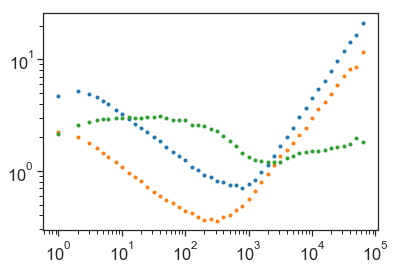

In [131]:
taus_in = np.round(np.power(10, np.arange(0,6,0.1)))

# taus, adev, _, _ = allantools.totdev((moment_df_2['tr,m1']-vtm_df_2['st5,m1']).values, data_type='freq', rate=1, taus=taus_in)
# plt.loglog(taus, adev, '.')

# taus, adev, _, _ = allantools.totdev((moment_df_2['tr,m1']-0.5*vtm_df_2['st4,m1']-0.5*vtm_df_2['st6,m1']).values, data_type='freq', rate=1, taus=taus_in)
# plt.loglog(taus, adev, '.')

# taus, adev1, _, _ = allantools.adev((moment_no8_df_2['tr,m1']-vtm_df_2['st5,m1']).values, data_type='freq', rate=1, taus=taus_in)
# plt.loglog(taus, adev1, '.')

taus, adev1, _, _ = allantools.adev((moment_no8_df_2['tr,m1']
                                     -0.5*vtm_df_2['st4,m1']
                                     -0.5*vtm_df_2['st6,m1']
                                     
                                    ).values,
                                    data_type='freq', rate=1, taus=taus_in)
plt.loglog(taus, adev1, '.')

# taus, adev2, _, _ = allantools.adev((moment_no8_df_2['tr,m1']-0.5*vtm_df_2['st4,m1']-0.5*vtm_df_2['st6,m1']).values, data_type='freq', rate=1, taus=taus_in)
# plt.loglog(taus, adev2, '.')

taus, adev2, _, _ = allantools.adev((moment_no8_df_2['tr,m1']
                                     -0.5*vtm_df_2['st71,m1']
                                     -0.5*vtm_df_2['st11,m1']
                                     
                                    ).values,
                                    data_type='freq', rate=1, taus=taus_in)
plt.loglog(taus, adev2, '.')

# taus, adev, _, _ = allantools.ohdev((moment_no8_df_2['tr,m1']-vtm_df_2['st5,m1']).values, data_type='freq', rate=1, taus=taus_in)
# plt.loglog(taus, adev, '.')

plt.loglog(taus, adev1/adev2, '.')
print adev1[-1]/adev2[-1]

# taus, adev, _, _ = allantools.ohdev((moment_no8_df_2['tr,m1']-0.5*vtm_df_2['st4,m1']-0.5*vtm_df_2['st6,m1']).values, data_type='freq', rate=1, taus=taus_in)
# plt.loglog(taus, adev, '.')


In [106]:
np.max(taus)/60/60

17.526666666666664

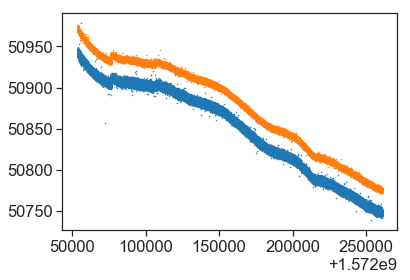

In [59]:
plt.plot(moment_no8_df_2.index.values, moment_no8_df_2['tr,m1'], '.', markersize=1)
plt.plot(interp_no8_df_2.index.values, interp_no8_df_2['tr0'], '.', markersize=1)

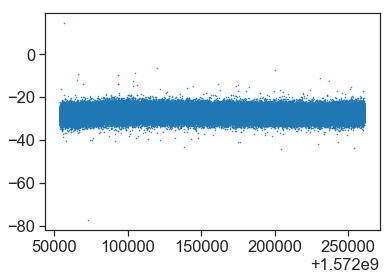

In [60]:
plt.plot(moment_no8_df_2.index.values, moment_no8_df_2['tr,m1']-interp_no8_df_2['tr0'], '.', markersize=1)

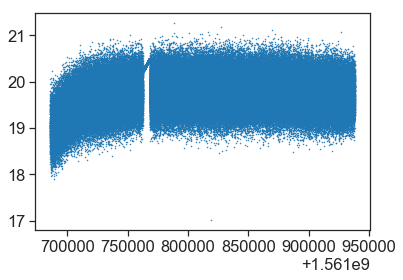

In [61]:
plt.plot(moment_df_1.index.values, moment_df_1['tr,m1']-interp_df_1['tr0'], '.', markersize=1)

In [19]:
interp_df_3 = pd.read_hdf('hdf5/60hr.h5', 'tr_df_1')

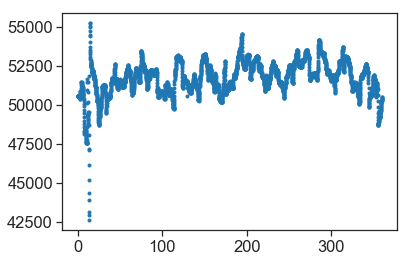

In [21]:
plt.plot(interp_df_3['tr_phi'], interp_df_3['tr8'], '.')

(-3000, 3000)

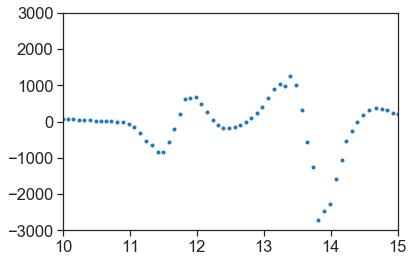

In [32]:
plt.plot(interp_df_3['tr_phi'].iloc[0:-1], np.diff(interp_df_3['tr8']), '.')

plt.xlim(10,15)
plt.ylim(-3000,3000)

(-3000, 3000)

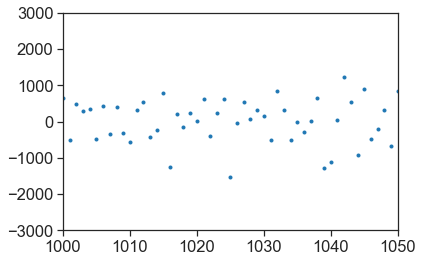

In [31]:
plt.plot(np.diff(interp_df_2['tr8']), '.')

plt.xlim(1000,1050)
plt.ylim(-3000,3000)